In [ ]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy
import os

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

Device: cuda


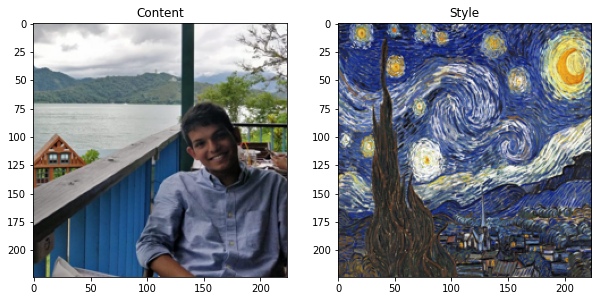

In [ ]:
style_img = Image.open("van_gogh.jpg").resize((224,224))
content_img = Image.open("content.jpeg").resize((224,224))

fig,ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(content_img)
ax[0].set_title("Content")
ax[1].imshow(style_img)
ax[1].set_title("Style")
plt.show()

In [ ]:
def compute_content_loss(content_activations, input_activations):
    loss = 0
    for content_act, input_act in zip(content_activations, input_activations):
        loss += F.mse_loss(content_act, input_act)
    return loss

def compute_style_loss(content_activations, input_activations):
    loss = 0
    for content_act, input_act in zip(content_activations, input_activations):
        loss += F.mse_loss(content_act, input_act)
    return loss

def gram_matrix(x):
    return torch.matmul(x, x.t()) / (x.shape[0] ** 2)

In [ ]:
class StyleGenerator(nn.Module):
    def __init__(self, style_path, content_path, style_layers = [1, 2, 3, 4, 5], content_layers = [4]):
        '''
        Inputs:
            style_path: Path to style image
            content_path: Path to content image
            style_layers: nn.Conv2D layers that are required for style activations
            content_layers: nn.Conv2D layers that are required for content activations
        '''
        super(StyleGenerator, self).__init__()

        # Set image paths
        self.style_path = style_path
        self.content_path = content_path

        # Set required conv layers for content and style activations
        self.content_layers = content_layers
        self.style_layers = style_layers
        
        # Initialize vgg model and all params are not learnable
        self.net = models.vgg19(pretrained = True).features.to(device)
        for layer in self.net:
            layer.requires_grad = False
        
        # Set preprocessing transforms based on vgg type inputs
        self.preprocess = transforms.Compose([transforms.ToTensor(),
                                              transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                  std=[0.229, 0.224, 0.225])])
        
        self.postprocess = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                                               ])

    def getActivations(self, x):
        '''
        Input:
            x: An Image tensor of the form (n, B, H, W)
        Output: 
            content_activations: List of activated flatenned activated tensors
            style_activations: List of activated style tensors (shape : (C, H* W))
        '''
        conv_count = 0
        max_count = max(max(self.content_layers), max(self.style_layers))
        
        # stores indices from the vgg network of the Conv2D layers
        style_activations = []
        content_activations = []
        for i, layer in enumerate(self.net):
            x = layer(x)
            if isinstance(layer, nn.Conv2d):
                conv_count += 1
                if conv_count in self.style_layers:
                    style_activations.append(x.view(x.shape[1], -1))
                if conv_count in self.content_layers:
                    content_activations.append(x.flatten())
        return style_activations, content_activations

    def generate_stylized_image(self, output_dir = "/content", content_wt = 1.0, style_wt = 100.0, 
                                learning_rate = 1.0, num_steps = 500, image_size = (224, 224)):
        '''
        Inputs:
            content_path: path to content image
            style_path: path to style image
            output_dir: output directory for intermediate generated images
            
            content_wt: factor controlling contribution of content loss to total loss
            style_wt: factor controlling contribution of style loss to total loss
            
            learning_rate: learning rate of optimizer
            num_steps: number of steps to be taken by optimizer
            
            image_size: tuple indicating size of input and output images to be used, default is input size expected by VGG19
        '''
        # Create output directory
        if not os.path.exists(output_dir):
            os.mkdir(output_dir)
        
        # Load content and style images and compute relevant activations
        content_img = Image.open(self.content_path).resize(image_size)
        style_img = Image.open(self.style_path).resize(image_size)
        
        content = self.preprocess(content_img).unsqueeze(0).to(device)
        style = self.preprocess(style_img).unsqueeze(0).to(device)

        # get content and style activations from getActivation and they are not learnable
        content_activations = [x.detach() for x in self.getActivations(content)[1]]
        style_activations = [gram_matrix(x.detach()) for x in self.getActivations(style)[0]]

        # initialize output image as content_image + gaussian_noise for faster convergence
        gaussian_noise = torch.clamp(torch.randn(1, 3, image_size[0], image_size[1]), -1, 1).to(device)
        gen_image = content * 0.5 + gaussian_noise * 0.5
        gen_image = nn.Parameter(gen_image)

        # initialize optimizer with gen_image as parameters over which optimization is carried out
        optimizer = torch.optim.LBFGS([gen_image.requires_grad_()], lr=learning_rate)

        steps = [0]
        while steps[0]<num_steps:
            def closure():
                '''
                closure function required by LBFGS optimizer
                '''
                optimizer.zero_grad()
                
                inp_style, inp_content = self.getActivations(gen_image)
                inp_style = [gram_matrix(x) for x in inp_style]

                content_loss = compute_content_loss(content_activations, inp_content)
                style_loss = compute_style_loss(style_activations, inp_style)
                loss = content_wt * content_loss + style_wt * style_loss
                steps[0] += 1
                if steps[0] % 50 == 0:
                    print("Num Steps: {} \tContent Loss: {} \tStyle Loss: {} \tTotal Loss:{}".format(steps[0], 
                                round(content_loss.item(),3), round(style_loss.item(),3), round(loss.item(),3)))

                loss.backward()
                return loss
            optimizer.step(closure)

        fig,ax = plt.subplots(1,3, figsize=(15,7))
        ax[0].imshow(content_img)
        ax[0].set_title("Content")
        ax[1].imshow(style_img)
        ax[1].set_title("Style")
        ax[2].imshow(torch.clamp(self.postprocess(gen_image[0].cpu().detach()).permute(1, 2, 0),0, 1).numpy())
        ax[2].set_title("Generated Image")
        plt.show()
        fig.savefig(os.path.join(output_dir,"final.jpg"))

Num Steps: 50 	Content Loss: 3.778 	Style Loss: 0.072 	Total Loss:4.496
Num Steps: 100 	Content Loss: 2.887 	Style Loss: 0.046 	Total Loss:3.351
Num Steps: 150 	Content Loss: 2.674 	Style Loss: 0.042 	Total Loss:3.093
Num Steps: 200 	Content Loss: 2.593 	Style Loss: 0.041 	Total Loss:2.999
Num Steps: 250 	Content Loss: 2.554 	Style Loss: 0.04 	Total Loss:2.951
Num Steps: 300 	Content Loss: 2.531 	Style Loss: 0.039 	Total Loss:2.924
Num Steps: 350 	Content Loss: 2.517 	Style Loss: 0.039 	Total Loss:2.906
Num Steps: 400 	Content Loss: 2.507 	Style Loss: 0.039 	Total Loss:2.894
Num Steps: 450 	Content Loss: 2.499 	Style Loss: 0.039 	Total Loss:2.886
Num Steps: 500 	Content Loss: 2.494 	Style Loss: 0.039 	Total Loss:2.88


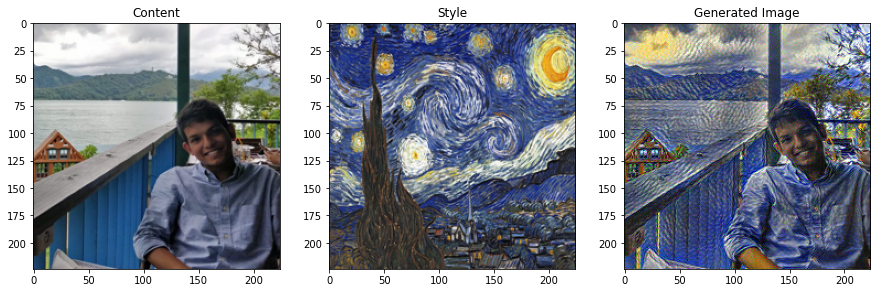

In [ ]:
styler = StyleGenerator(style_path="van_gogh.jpg", content_path="content.jpeg")
styler.generate_stylized_image(output_dir='/content', style_wt=10.0)